https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from dotenv import load_dotenv
from langchain_upstage import UpstageEmbeddings
from langchain_chroma import Chroma

embeddings = UpstageEmbeddings(model="solar-embedding-1-large")

vector_store = Chroma(collection_name="income_tax_collection",
                      embedding_function=embeddings,
                      persist_directory="./income_tax_collection")

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
query = "연봉 5천만원 직장인의 소득세는?"
retriever.invoke(query)

[Document(id='c7dd2fe8-b674-487f-ae1d-2d11d3e809ea', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우: 연 15만원\n2명인 경우: 연 35만원\n3명 이상인 경우: 연 35만원과

### 1. state, graph_builder 정의

In [4]:
# START -> retrieve -> generate -> END
#       <- rewrite <-
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list[Document]
    answer: str

graph_builder = StateGraph(AgentState)

### 2. node에 들어갈 fucntion 정의

In [5]:

def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    print(docs)
    return {'context': docs}

In [6]:
from langchain import hub
from langchain_upstage import ChatUpstage
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    query = state['query']
    context = state['context']
    # 이곳에 StrOutputParser를 붙이지 않으면 rag_chain의 결과가 llm의 답변인 Message 객체가 됨
    # 하지만 우리 state에서 'answer'의 type은 str이므로 str로 바꿔줘야함
    # 여기서는 바꾸지 않아도 에러가 안나지만 에러가 날 때도 있다고 한다. 그건 나중에 공부해보자자
    rag_chain = generate_prompt | llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
from typing import Literal
from langchain import hub

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(context)
    print(response)
    if response['Score'] == 1:
        return 'generate'
    else:
        return 'rewrite'

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

keword_dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
    사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
    사전: {keword_dictionary}                                           
    질문: {{query}}
    """
)

def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': query}

In [ ]:
from langgraph.graph import START, END

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_doc_relevance,
    {
        "generate": "generate",
        "rewrite": "rewrite"
    })
graph_builder.add_edge("rewrite", "retrieve")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

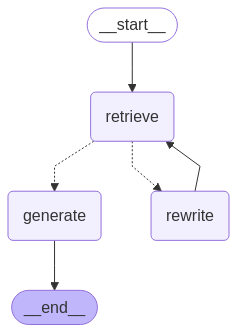

In [10]:
from IPython.display import Image, display

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
query = "연봉 5천만원 직장인의 세금은?"
initial_state = {'query': query}
graph.invoke(initial_state)

[Document(id='c7dd2fe8-b674-487f-ae1d-2d11d3e809ea', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우: 연 15만원\n2명인 경우: 연 35만원\n3명 이상인 경우: 연 35만원과

{'query': '연봉 5천만원 직장인의 세금은?',
 'context': [Document(id='c7dd2fe8-b674-487f-ae1d-2d11d3e809ea', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우:

In [12]:
# Literal
# Hashable
# Runable
# Callable 정리

# 그럼 conditional edge에 들어가는 함수는 노드로 등록할 필요도 없는것인가? gpt와 공식문서는 어떻게 했는지 알아보자
# 어떻게 Literal 하나 붙인다고 그게 동작하지? 원리가 궁금하다.